In [2]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Dataset Structure

In [8]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
dataset1.element_spec # information about each element

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [13]:
dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]),
    tf.random.uniform([4, 100]))
)
dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.float32, name=None))

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.float32, name=None)))

In [31]:
ex = list(dataset3.take(1).as_numpy_iterator())[0]
print(ex[0].shape)
print(ex[1][0].shape, ex[1][1].shape)

(10,)
() (100,)


In [36]:
for a, (b, c) in dataset3.take(1):
    print(a, end='\n\n')
    print(b, end='\n\n')
    print(c)

tf.Tensor(
[0.49532723 0.11663938 0.13906896 0.09886837 0.98519576 0.25012946
 0.69974387 0.32797801 0.42015362 0.6285492 ], shape=(10,), dtype=float32)

tf.Tensor(0.58702254, shape=(), dtype=float32)

tf.Tensor(
[0.9107101  0.17592347 0.7778163  0.1731149  0.7221385  0.7210685
 0.9420247  0.06437552 0.9133631  0.29064798 0.7580303  0.1185416
 0.88584137 0.02779925 0.9734049  0.58190286 0.764647   0.5077865
 0.8442658  0.00724649 0.81334984 0.83103764 0.9885924  0.10921192
 0.19971466 0.57581294 0.05426264 0.39239    0.74225235 0.9156666
 0.16330743 0.38125658 0.35224342 0.11791027 0.2655176  0.9727253
 0.5310886  0.99792516 0.7293167  0.8474854  0.8330718  0.7422962
 0.18464828 0.20496464 0.5637425  0.9218544  0.02146208 0.20749938
 0.18092728 0.6429994  0.11757445 0.85671556 0.52800894 0.20731664
 0.79331625 0.6806973  0.29803228 0.4672501  0.04052782 0.89549875
 0.6023766  0.02176571 0.40100312 0.87888    0.34674418 0.53520954
 0.42066252 0.8054693  0.93968225 0.11411798 0.73466563 

# Reading Input Data

## Consuming numpy arrays

In [39]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


In [42]:
images, labels = train
images = images / 255

dataset = tf.data.Dataset.from_tensor_slices(
    (images, labels)
)

dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

## Consuming Generators

In [43]:
def counter(stop):
    i = 0
    while i < stop:
        yield i
        i += 1

In [45]:
for n in counter(5):
    print(n)

0
1
2
3
4


In [46]:
ds_counter = tf.data.Dataset.from_generator(
    counter,
    args=[25],
    output_types=tf.int32,
    output_shapes=()
)

In [54]:
for count_batch in ds_counter.repeat().batch(10).take(10):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


In [56]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

228827136/228813984 [==============================] - 38s 0us/step


In [57]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [58]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [59]:
print(f"Images dtype:{images.dtype}, shape: {images.shape}")
print(f"Labels dtype:{labels.dtype}, shape:{labels.shape}")

Images dtype:float32, shape: (32, 256, 256, 3)
Labels dtype:float32, shape:(32, 5)


In [67]:
ds = tf.data.Dataset.from_generator(
    lambda : img_gen.flow_from_directory(flowers),
    output_types = (tf.float32, tf.float32),
    output_shapes=([32, 256, 256, 3], [32, 5])
)
ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

Found 3670 images belonging to 5 classes.
(256, 256, 3) (5,)


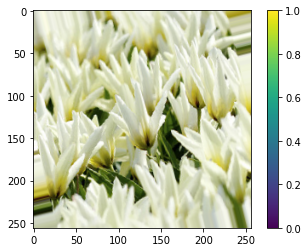

Label: [0. 0. 0. 0. 1.]


In [68]:
for image, label in ds.take(1):
    print(image[0].shape, label[0].shape)
    plt.imshow(image[0])
    plt.colorbar()
    plt.show()
    print(f"Label: {label[0]}")

## Consuming TFRecord Data

In [69]:
# French Street Name Signs
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7913472/7904079 [==============================] - 1s 0us/step


In [71]:
ds = tf.data.TFRecordDataset(filenames=[fsns_test_file])
ds

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [79]:
raw = next(iter(ds))

parsed = tf.train.Example.FromString(raw.numpy())
parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

# Training Workflows : Shuffle, Batch, Repeat

## Processing Multiple Epochs :  Repeat & Batch

In [81]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

40960/30874 [=======================================] - 0s 0us/step


In [85]:
print(f"Number of training samples: {len(list(titanic_lines))}")

Number of training samples: 628


In [88]:
batches = titanic_lines.repeat(3).batch(128)
batches

<BatchDataset shapes: (None,), types: tf.string>

In [91]:
for batch in batches.take(1):
    print(batch.shape)

(128,)


In [97]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')


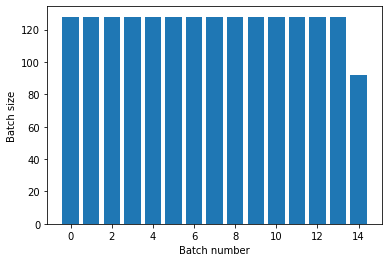

In [99]:
# Repeat -> Batch
plot_batch_sizes(batches)

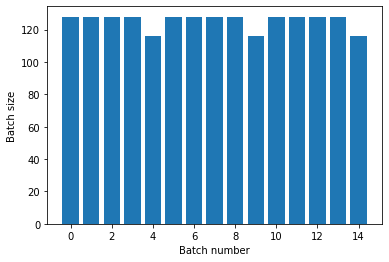

In [100]:
# Batch -> Repeat
batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(batches)

In [101]:
epochs = 3
batches = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in batches:
        print(batch.shape)
    print(f"end of epoch: {epoch}")

(128,)
(128,)
(128,)
(128,)
(116,)
end of epoch: 0
(128,)
(128,)
(128,)
(128,)
(116,)
end of epoch: 1
(128,)
(128,)
(128,)
(128,)
(116,)
end of epoch: 2


## Shuffle

The Dataset.shuffle() transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer.

In [104]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)

Since the buffer_size is 100, and the batch size is 20, the first batch contains no elements with an index over 120.

In [108]:
for n, line_batch in dataset.take(1):
    print(n.numpy())

[ 96  82  76  93  73 102  27  59  66  87  25  43  23 106  52  36  74  40
 108   9]


Dataset.shuffle doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next: 

In [129]:
lines = tf.data.TextLineDataset(titanic_file)
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Number of batches in one epoch: ", len(list(shuffled))//2)

Number of batches in one epoch:  63


In [130]:
print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[609 535 536 502 579 584  21 317 617 624]
[537 551 558 458 572 589 329 478 615 250]
[625 525 591 497 596 602 608 577]
[ 7 65 96 84 98  8 28 13 97 62]
[78 53 47 51 12 67 18 75 54 36]


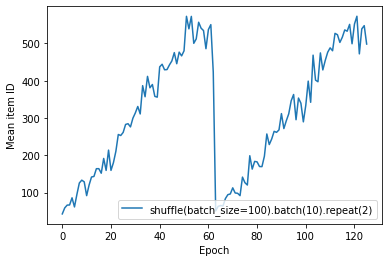

In [131]:
shuffle_repeat = [n.numpy().mean() for n, batch in shuffled]
plt.plot(shuffle_repeat, label='shuffle(batch_size=100).batch(10).repeat(2)')
plt.xlabel('Epoch')
plt.ylabel('Mean item ID')
plt.legend()

But a repeat before a shuffle mixes the epoch boundaries together:

Here are the item ID's near the epoch boundary:

[467 559  10 606 458 539 609 625   4  21]
[618 608  20 477 573  28 548 615 437  40]
[610 616 107 582  13 545 361 594  48 590]
[442  39  23 394  31  34 622  51  30  42]
[  3  60  52 598 450 568  17 600  53  50]
[ 36 605  32  49  74 337  66 603 347 514]
[ 59   2  67  24  35  38  69  22   7 583]
[ 43 344  84 596 552 312  89  63  97  19]
[617 580  99  72 597  15  54 540  95 452]
[604 110  16  64  90 564 109  77  70  85]
[121 532  45 549  78 602  14 541  86  91]
[104 122  92 114  81 111  79 529  55  12]
[100 607  82  98 112 119 103  71  29 105]
[507 589  25 134  47 132 131 123 115 453]
[ 62 149 151  88  18 161  87   9 136  93]


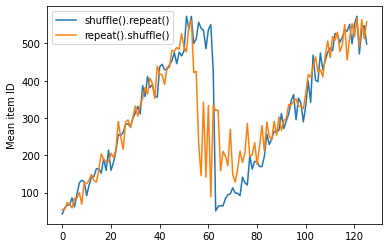

In [132]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()
